### Basic forward integration of an ODE
Consider the following time-dependent ODE

$$[\overset{.}{z_1}, \overset{.}{z_2}] =  [w_1 z_2, - w_2 z_1 \exp(-w_3 t)]$$

This of $z_1$ as position and $z_2$ as velocity. The $\exp(-t)$ means that the ODE is a spring that gets weaker with time. Note that any time-dependent ODE can be turned into a time-independent ODE, e.g.

$$[\overset{.}{z_1}, \overset{.}{z_2}, \overset{.}{z_3}] =  [w_1 z_2, -w_2 z_1 \exp(-w_3 z_3), 1]$$

So with this trick we don't need to worry about time and state separately. time is part of the state. Now let's install torchdiffeq.

In [2]:
!pip install git+https://github.com/rtqichen/torchdiffeq --user

  Cloning https://github.com/rtqichen/torchdiffeq to /private/var/folders/dm/5q8sftvx0dz2sc8xm3h_8mzjphpx35/T/pip-req-build-gad3h4ra
  Stored in directory: /private/var/folders/dm/5q8sftvx0dz2sc8xm3h_8mzjphpx35/T/pip-ephem-wheel-cache-ra3kujt4/wheels/3f/76/69/01867bf3355c3bc8bae7e556b17b44c395b6cda5e76fd8ddc7
Successfully built torchdiffeq


As a first step, we are just going to run the `torchdiffeq` integrator in forward mode, starting from an initial value, with fixed values of $[w_1, w_2, w_3]$ for a fixed amount of time and observe what happens. 

In [1]:
from torchdiffeq import odeint
import torch
from torch import tensor, exp, stack

def gradient_model(w):
    def gradient(t, state):
        return stack([w[0] * state[1],  - w[1] * state[0] * exp(- w[2] * t)])
    return gradient

w = tensor([1.0, 1.0, 1.0])
iv = tensor([0.0, 1.0])
T_initial, T_final = 0, 10
T = T_final - T_initial
t_series = torch.linspace(T_initial, T_final, 100)

In [2]:
ode = gradient_model(w)
states = odeint(ode, iv, t_series)

<IPython.core.display.Javascript object>


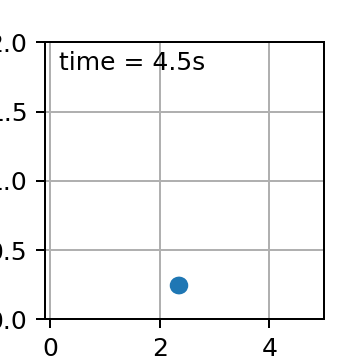

In [12]:
%matplotlib notebook
from IPython.display import HTML

from animate import animate
import matplotlib.pyplot as plt
anim = animate(*zip(*states), T/100, (2, 2))
plt.xlim(-0.1, 5)
plt.ylim(0, 2)
plt.grid(True)
plt.xlabel('position')
plt.ylabel('velocity')
plt.show()
# HTML(anim.to_html5_video())

It is possible to backpropagate through the ode integrator in a naive way, by treating the integrator as a big sequence of computations which can be backpropagated through. However the NODE paper advocates -- for efficiency reasons -- to use the adjoints for computing the gradients of:

1. The parameters in the ODE `w`
2. The initial value `iv`
3. The initial and final time `T_initial` and `T_final`

with respect to a loss that is computed from the value of the state at time `T_final`. Obviously, its not necessary that the arg-min of the loss is unique. 

Let's say that we want the position and velocity at time $10$ to be $[4, 1]$ respectively. But, with the values of `w, iv, T_initial, T_final` that we set above the `[z_1, z_2]` vector is something else. 

In [4]:
print('time =', t_series[-1].item(), '\n[z_1, z_2] =', states[-1].tolist())

time = 10.0 
[z_1, z_2] = [3.583651304244995, 0.22406360507011414]


How should we tweak the parameters of the ODE? **First let us see how we can change the parameters `w`?**

In [5]:
import torch.optim
from torchdiffeq import odeint_adjoint
from tqdm.notebook import tqdm
def L(final_state):
    return (final_state[-1][0] - 4) ** 2 + (final_state[-1][1] - 1) ** 2

In [6]:
class ODEFunc(torch.nn.Module):
    def __init__(self, w):
        super().__init__()
        self.w = torch.nn.Parameter(w)
        
    def forward(self, t, state):
        return gradient_model(self.w)(t, state)
    
w = tensor([1.0, 1.0, 1.0])
ode_func = ODEFunc(w)
optimizer = torch.optim.RMSprop(ode_func.parameters(), lr=6e-3)
W, F = [], []
for itr in tqdm(range(100)):
    optimizer.zero_grad()
    final_state = odeint_adjoint(ode_func, iv, tensor([0., 10.]))
    W.append(w.tolist())
    F.append(final_state[-1].tolist())
    L(final_state).backward()
    optimizer.step()

### Evolution of the final value 

<IPython.core.display.Javascript object>


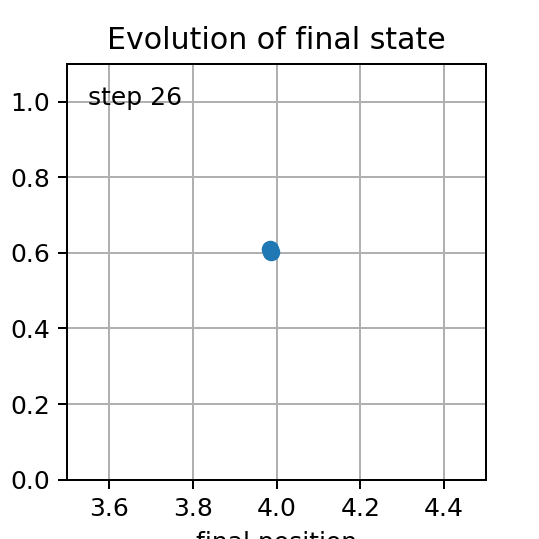

[1.0, 1.0, 1.0] [0.4806376099586487, 0.7049875259399414, 1.265218734741211]


In [7]:
ani = animate(*zip(*F), T/100, (3, 3), (lambda i: f'step {i}'))
plt.xlim(3.5, 4.5)
plt.ylim(0, 1.1)
plt.grid(True)
plt.xlabel('final position')
plt.ylabel('final velocity')
plt.title('Evolution of final state')
plt.show()
print(W[0], W[-1])

Similarly we can compute gradients with respect to the initial value `iv`

In [8]:
import torch.optim
from torchdiffeq import odeint_adjoint
from tqdm.notebook import tqdm

class ODEFunc2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, t, state):
        return gradient_model(tensor([0.4806376099586487, 0.7049875259399414, 1.265218734741211]))(t, state)

iv_param = torch.nn.Parameter(tensor([0.0, 1.0]))
optimizer = torch.optim.RMSprop([iv_param], lr=1e-5)
I, F = [iv_param.tolist()], []
for itr in tqdm(range(5)):
    optimizer.zero_grad()
    z_final = odeint_adjoint(ODEFunc2(), iv_param, tensor([0., 10.]))
    F.append(z_final[-1].tolist())
    loss = L(z_final)
    loss.backward()
    optimizer.step()
    iv_param.data.clamp_(0, float('inf'))
    I.append(iv_param.tolist())

print(F[0], F[-1])
print(I[0], I[-1])


[3.9899959564208984, 0.7992744445800781] [3.9911060333251953, 0.7994970679283142]
[0.0, 1.0] [0.0, 1.0003228187561035]
